In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
x_train = pd.read_csv('data/train.csv', engine='pyarrow').drop(columns=['SAMPLE_ID', 'ID'])
x_val = pd.read_csv('data/test.csv', engine='pyarrow').drop(columns=['SAMPLE_ID', 'ID'])
x_train.ATA = pd.to_datetime(x_train.ATA, format='%Y-%m-%d %H:%M:%S')
x_train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29:00,30.0,24,24300,10.0,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 06:59:00,30.0,13,35900,10.0,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00:00,50.0,12,146000,30.0,20.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 04:02:00,20.0,18,6910,10.0,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 07:51:00,50.0,10,116000,20.0,10.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 05:02:00,20.0,27,6820,10.0,10.0,...,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 00:36:00,10.0,12,3160,10.0,10.0,...,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35:00,30.0,8,60300,20.0,10.0,...,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 07:15:00,30.0,29,23800,10.0,10.0,...,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


# Categorical Columns

In [3]:
for cat_col in x_train.columns[x_train.dtypes=='object']:
    num_of_values = x_train[cat_col].value_counts().shape[0]
    print(f'{cat_col:18s} has {num_of_values:5d} kinds of values')

ARI_CO             has    25 kinds of values
ARI_PO             has   103 kinds of values
SHIP_TYPE_CATEGORY has     4 kinds of values
SHIPMANAGER        has  6566 kinds of values
FLAG               has   125 kinds of values


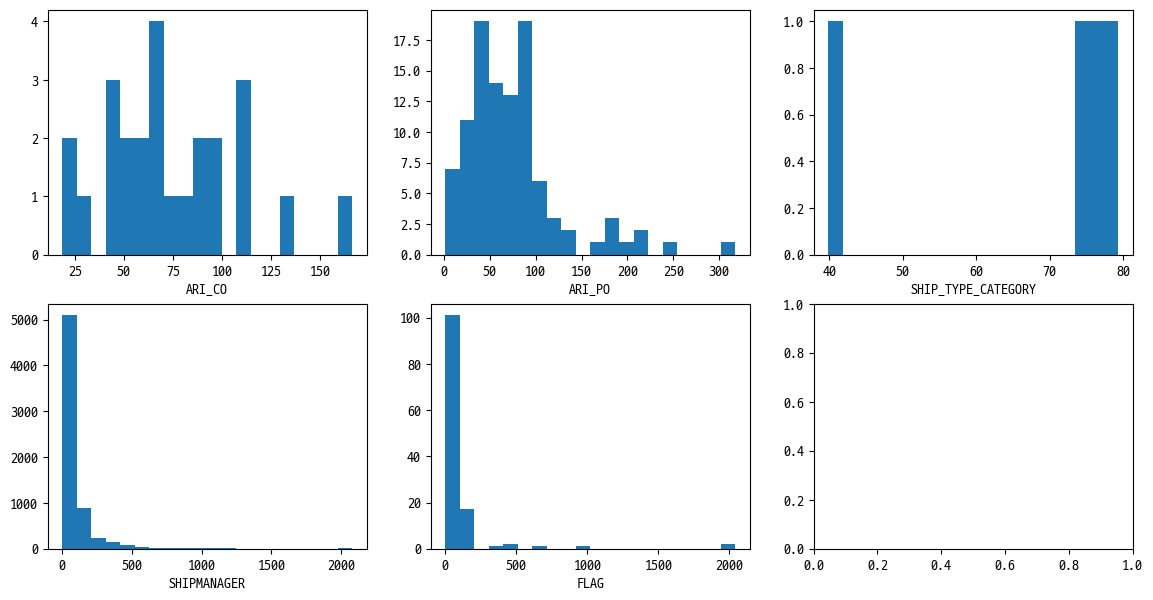

In [4]:
fig, axes = plt.subplots(2, 3, dpi=100, figsize=(14, 7))
for ax, cat_col in zip(axes.ravel(), x_train.columns[x_train.dtypes=='object']):
    temp = x_train.groupby(cat_col)['CI_HOUR'].mean().values
    ax.hist(temp, bins=20)
    ax.set_xlabel(cat_col)

# Numerical Columns

## `NaN` checking

In [5]:
x_train.loc[:, x_train.columns[x_train.dtypes==float]].isnull().sum(axis=0)

DIST                    0
BREADTH                 1
DEPTH                   1
DRAUGHT                 1
LENGTH                  1
U_WIND             163688
V_WIND             163688
AIR_TEMPERATURE    164630
BN                 163688
PORT_SIZE               0
CI_HOUR                 0
dtype: int64

In [6]:
for col in ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']:
    print(x_train.index[x_train[col].isnull()].item())

356484
356484
356484
356484


In [7]:
x_train.drop(index=356484, inplace=True)
x_train.loc[:, x_train.columns[(x_train.dtypes==np.int64) | (x_train.dtypes==np.float64)]].isnull().sum(axis=0)

DIST                    0
BREADTH                 0
BUILT                   0
DEADWEIGHT              0
DEPTH                   0
DRAUGHT                 0
GT                      0
LENGTH                  0
U_WIND             163688
V_WIND             163688
AIR_TEMPERATURE    164630
BN                 163688
ATA_LT                  0
PORT_SIZE               0
CI_HOUR                 0
dtype: int64

+ `U_WIND`, `V_WIND`, `BN` have same indices of `NaN`.
+ `AIR_TEMPERATURE` has dfferent indices of `NaN`.

In [8]:
nan_indices = x_train.index[x_train.U_WIND.isnull()]
for col in ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']:
    temp = x_train.index[x_train[col].isnull()]
    if len(nan_indices) == len(temp):
        print(f'{col:15s}', set(nan_indices) == set(temp))

U_WIND          True
V_WIND          True
BN              True


In [9]:
count = 0
for nan_index in x_train.index[x_train.AIR_TEMPERATURE.isnull()]:
    if nan_index not in nan_indices:
        count += 1

print(count)

942


+ $942 = 164630 - 163688$.
+ `153,486` rows includes `NaN` for column `U_WIND`, `V_WIND`, `BN`, `AIR_TEMPERATURE`. Especially, `AIR_TEMPERATURE` has `879` more `NaN` values.

## Correlation

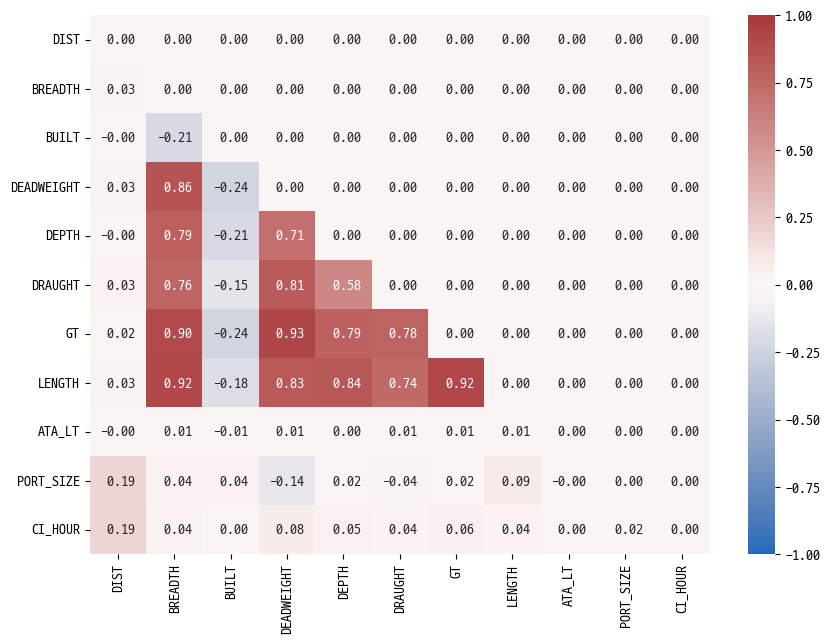

In [10]:
num_nonan = list(x_train.columns[(x_train.dtypes==np.int64) | (x_train.dtypes==np.float64)])
num_nonan = [num_col for num_col in num_nonan if num_col not in ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]
corr_matrix = np.corrcoef(x_train.loc[:, num_nonan].values.T)
corr_matrix = np.tril(corr_matrix)
np.fill_diagonal(corr_matrix, 0)

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(10, 7))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap=cmap, fmt='5.2f', annot=True, )
ax.set_xticklabels(num_nonan, rotation=90)
ax.set_yticklabels(num_nonan, rotation=0)
None

In [11]:
temp = x_train.loc[:, ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'CI_HOUR']]
temp.drop(index=temp.index[temp['AIR_TEMPERATURE'].isnull()], inplace=True)
corr = np.corrcoef(temp.values.T)
corr = np.tril(corr)
corr

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09486857,  1.        ,  0.        ,  0.        ,  0.        ],
       [-0.11179176,  0.18632936,  1.        ,  0.        ,  0.        ],
       [-0.09498148, -0.18335582, -0.00282861,  1.        ,  0.        ],
       [-0.01218151,  0.01746078,  0.03582792, -0.01692156,  1.        ]])

## Scatter Plot

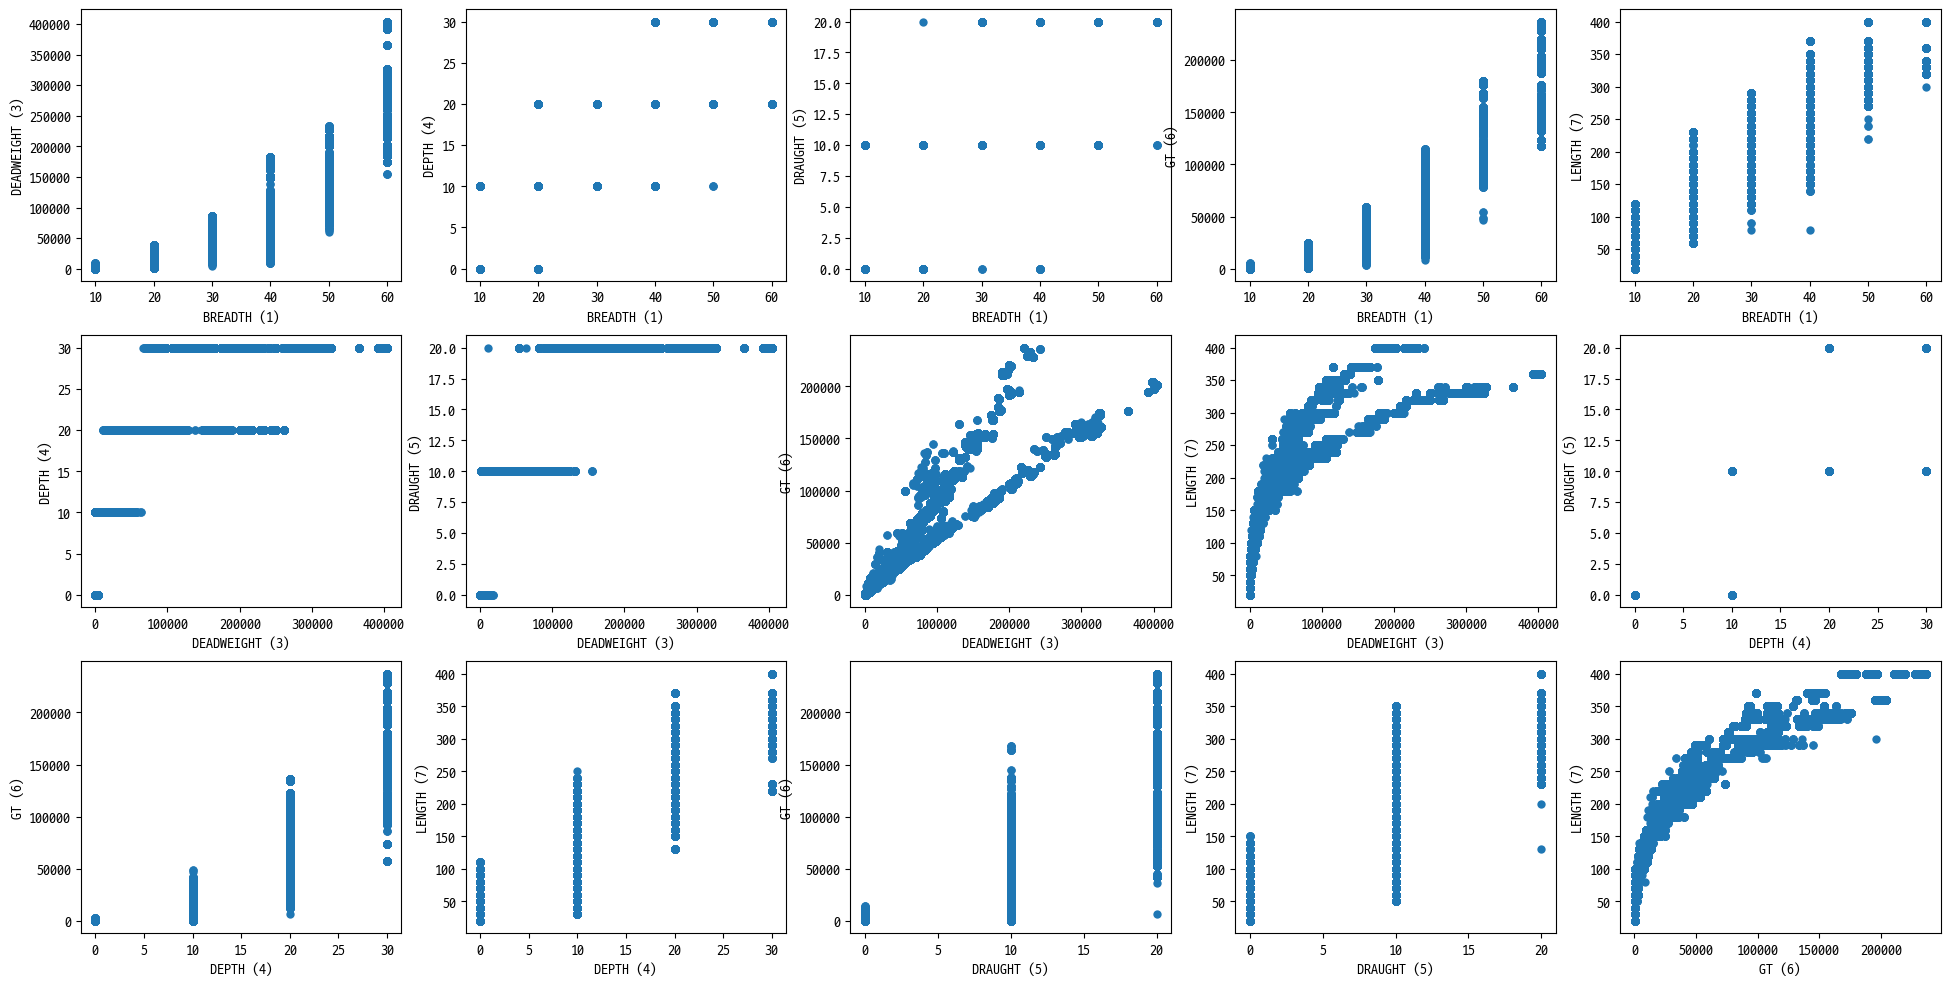

In [12]:
from itertools import combinations

fig, axes = plt.subplots(3, 5, dpi=100, figsize=(24, 12))
axis_indices = list(combinations([1, 3, 4, 5, 6, 7], 2))

for (x_index, y_index), ax in zip(axis_indices, axes.ravel()):
    sns.scatterplot(data=x_train, x=num_nonan[x_index], y=num_nonan[y_index], linewidth=0, ax=ax)
    ax.set_xlabel(f'{num_nonan[x_index]} ({x_index})')
    ax.set_ylabel(f'{num_nonan[y_index]} ({y_index})')

### Deletion of Identical columns & Addition of Clusters

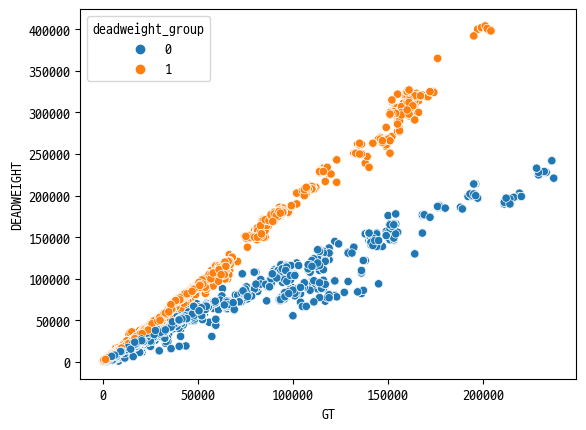

In [13]:
cluster_index = np.abs(x_train['DEADWEIGHT'] - 2*x_train['GT']) < np.abs(x_train['DEADWEIGHT'] - x_train['GT'])
x_train['deadweight_group'] = 0
x_train.loc[cluster_index, 'deadweight_group'] = 1

sns.scatterplot(data=x_train, x='GT', y='DEADWEIGHT', hue='deadweight_group'); 

### Deletion of Identical Columns

In [14]:
x_train.drop(columns=['LENGTH', 'DEADWEIGHT'], inplace=True)
x_val.drop(columns=['LENGTH', 'DEADWEIGHT'], inplace=True)